#### Imports

In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Analysis.Taxonomy import *

from MERFISH_Objects.FISHData import *

from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt 

#### Load data

In [2]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_1553498/676460092.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


#### Build layers 1-2: cells and zones

In [3]:
TMG = TissueMultiGraph()
TMG.create_cell_and_zone_layers(XY,data.X)

Build similarity graph 
calculation took: 281.51
Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208       -7.572        initial
    2        18.5792     -7.25862        golden
    3        7.15843     -7.58193        golden
    4        9.03094     -7.63639        parabolic
    5        9.24922      -7.5871        parabolic
    6        8.21395      -7.6102        parabolic
    7        8.71888     -7.60436        golden
    8        8.91174      -7.5929        golden
    9        9.11432     -7.62046        golden
   10        8.98541     -7.64499        golden
   11        8.95727     -7.60389        golden
   12         9.0028     -7.67891        golden
   13        9.00693      -7.6963        parabolic
   14         9.0161     -7.51152        golden
   15        9.01043      -7.6737        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.01 )
Initial entropy was: 

#### Show cond-entropy optimality

In [8]:
Gtotest = buildgraph(TMG.Layers[0].TX.data,metric = 'cosine')
EntropyCalcsL1 = TMG.Layers[0].calc_entropy_at_different_Leiden_resolutions(Gtotest)

Text(0, 0.5, 'Conditional entropy')

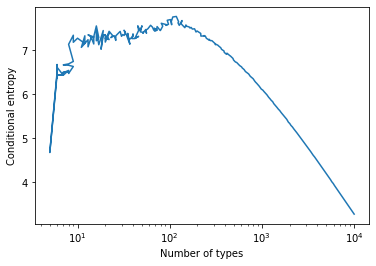

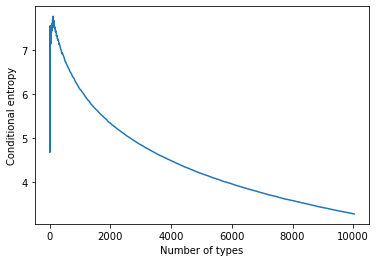

In [19]:
plt.semilogx(EntropyCalcsL1['Ntypes'],EntropyCalcsL1['Entropy'])
plt.xlabel('Number of types')
plt.ylabel('Conditional entropy')
plt.figure()
plt.plot(EntropyCalcsL1['Ntypes'],EntropyCalcsL1['Entropy'])
plt.xlabel('Number of types')
plt.ylabel('Conditional entropy')

#### Build layers 3-4: communities and regions 

In [11]:
TMG.create_communities_and_region_layers()

/home/rwollman/MyProjects/MaximallyInformativeBiocartography/dredFISH/dredFISH/Analysis/TissueGraph.py:652: RuntimeWarning: invalid value encountered in true_divide
  q = q_no/q_deno


Build similarity graph 
calculation took: 1.31
Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208     -1.65234        initial
    2        18.5792      -1.7104        golden
    3        22.9416     -1.77084        golden
    4        25.6376     -1.75735        golden
    5        23.3531      -1.7527        parabolic
    6        21.2753     -1.81168        golden
    7        20.2455     -1.75268        golden
    8        21.9118     -1.76527        golden
    9        20.8819     -1.81562        golden
   10        20.6388     -1.75104        golden
   11        21.0322     -1.71505        golden
   12        20.7891     -1.71812        golden
   13        20.9393     -1.71769        golden
   14        20.8465     -1.76419        golden
   15        20.9039     -1.72417        golden
   16        20.8684     -1.75035        golden
   17        20.8903     -1.74473        golden
   18        20.8768     -1.74655        golden
   

In [13]:
WatershedEnvs = TMG.Layers[3].TX.data
# ZoneTypes = TMG.Layers[2].Type.astype(np.int64)
# unqTypes = np.unique(ZoneTypes)
# for i in range(TMG.Layers[-1].N):
#     ix = np.where(TMG.Layers[-1].UpstreamMap==i)
#     WatershedEnvs[i,:] = count_values(ZoneTypes[ix].astype(np.int64),unqTypes,TMG.Layers[2].node_size[ix],norm_to_one=False)
            
# calcualte pairwise distances between environments using treenomialJSD
cmb = np.array(list(itertools.combinations(np.arange(WatershedEnvs.shape[0]), r=2)))
WatershedEnvs = torch.from_numpy(WatershedEnvs)
cmb = torch.from_numpy(cmb)
D = treenomialJSD(WatershedEnvs[cmb[:,0],:],WatershedEnvs[cmb[:,1],:])
Dsqr = squareform(D)

#### Show cond-entropy optimality

In [20]:
Gtotest = buildgraph(Dsqr,metric = 'precomputed')
EntropyCalcsL3 = TMG.Layers[3].calc_entropy_at_different_Leiden_resolutions(Gtotest)


Text(0, 0.5, 'Conditional entropy')

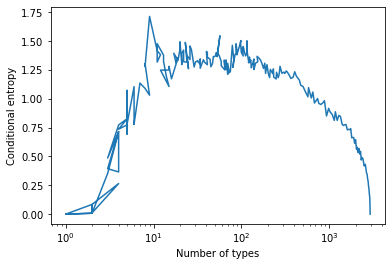

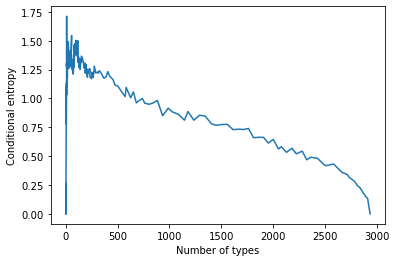

In [21]:
plt.semilogx(EntropyCalcsL3['Ntypes'],EntropyCalcsL3['Entropy'])
plt.xlabel('Number of types')
plt.ylabel('Conditional entropy')
plt.figure()
plt.plot(EntropyCalcsL3['Ntypes'],EntropyCalcsL3['Entropy'])
plt.xlabel('Number of types')
plt.ylabel('Conditional entropy')